In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from geopy.geocoders import Nominatim 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
#Source: http://www.pso.hochiminhcity.gov.vn/web/guest/niengiamthongke-nam2010-dansovalaodong
hcm_df = pd.read_csv('https://raw.githubusercontent.com/kikman-git/Coursera_Capstone/master/HCM_Pop.csv')
hcm_df.head()

,Id,Neighborhood,Population
0,404,District 1,187435
1,408,District 2,140621
2,409,District 3,188945
3,410,District 4,183261
4,411,District 5,174154


In [1]:
def get_latlong(neighborhood):
    """A function to get Latitude and Longitude using Google API"""
    import googlemaps
    gmaps = googlemaps.Client(key='API-Key')
    latlng =[]
    loading = 'Loading.'
    for i in neighborhood:
        string = '{}, Ho Chi Minh, Vietnam'.format(i)
        print(loading,end='')
        loading ='.'
        geocode_result = gmaps.geocode(string) #This will result in a json file so we need to know where to get the information
        latlng.append(geocode_result[0]['geometry']['location']) # location = (lat,lng)      
    return latlng   

In [5]:
latlng = get_latlong(hcm_df.Neighborhood.values)
latlng[:5]

Loading........................

[{'lat': 10.7756587, 'lng': 106.7004238},
 {'lat': 10.7872729, 'lng': 106.7498105},
 {'lat': 10.7843695, 'lng': 106.6844089},
 {'lat': 10.7578263, 'lng': 106.7012968},
 {'lat': 10.7540279, 'lng': 106.6633746}]

In [6]:
def get_latlng(df,latlng):
    lat_list =[]
    lng_list =[]
    for i in latlng:
        lat_list.append(i['lat'])
        lng_list.append(i['lng'])
    df['Latitude'] = lat_list
    df['Longitude'] = lng_list
    return df

In [7]:
hcm_df = get_latlng(hcm_df, latlng)
hcm_df.head()

,Id,Neighborhood,Population,Latitude,Longitude
0,404,District 1,187435,10.775659,106.700424
1,408,District 2,140621,10.787273,106.749810
2,409,District 3,188945,10.784370,106.684409
3,410,District 4,183261,10.757826,106.701297
4,411,District 5,174154,10.754028,106.663375


In [8]:
url = 'https://raw.githubusercontent.com/kikman-git/Coursera_Capstone/master/ho_chi_minh_city.json'
hcm_json = requests.get(url).json()

#### Choropleth Map 

In [77]:
address = 'Ho Chi Minh, Vietnam'

geolocator = Nominatim(user_agent="tokyo_explorer")
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude

m = folium.Map([lat,long], zoom_start=9.5,tiles='cartodbpositron')
choropleth = folium.Choropleth(
    geo_data=hcm_json,
    data=hcm_df,
    columns=['Id','Population'],
    key_on='feature.properties.ID_3', 
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Ho Chi Minh Population',
    highlight=True,
    line_color='black'
).add_to(m)

folium.LayerControl(collapsed=True).add_to(m)
for i in range(0,len(count_df)):
   folium.Circle(
     location=[count_df.iloc[i]['Latitude'], count_df.iloc[i]['Longitude']],
      geo_data="hcm",
       popup=str(count_df.iloc[i]['Neighborhood'])+":"+str(count_df.iloc[i]['Venues']),
      radius=float(count_df.iloc[i]['Venues']*50),
      color='crimson',
      fill=True,
      fill_color='blue'
   ).add_to(m)
m

In [9]:
#Information for Foursquare API
CLIENT_ID = 'BECVQZKEXCCUXYVUV5TTYXQFTE2E3TACHNXYSBNL00QVVXAY' # your Foursquare ID
CLIENT_SECRET = 'WFXF553RQRLLNLPZXPSTAYQZIZKUJ1BW1IHOO4TVLBXXK21Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # top 100 venues

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    loading = 'Loading'
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(loading,end='')
        loading = '.'    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Done!')
    return(nearby_venues)

In [11]:
hcm_venue = getNearbyVenues(names = hcm_df['Neighborhood'],
                              latitudes = hcm_df['Latitude'],
                              longitudes = hcm_df['Longitude'])

Loading.......................Done!


In [12]:
hcm_venue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,District 1,10.775659,106.700424,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
1,District 1,10.775659,106.700424,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
2,District 1,10.775659,106.700424,B3 - Steakhouse & Craft Beer,10.775190,106.702492,Steakhouse
3,District 1,10.775659,106.700424,The Old Compass Cafe,10.774816,106.700685,Café
4,District 1,10.775659,106.700424,O Lé,10.774772,106.699524,Spanish Restaurant


In [13]:
print('There are {} uniques categories.'.format(len(hcm_venue['Venue Category'].unique())))

There are 83 uniques categories.


### Show top 15 neighborhood

Text(0.5, 1.0, 'Top 15 neighborhoods in Ho Chi Minh')

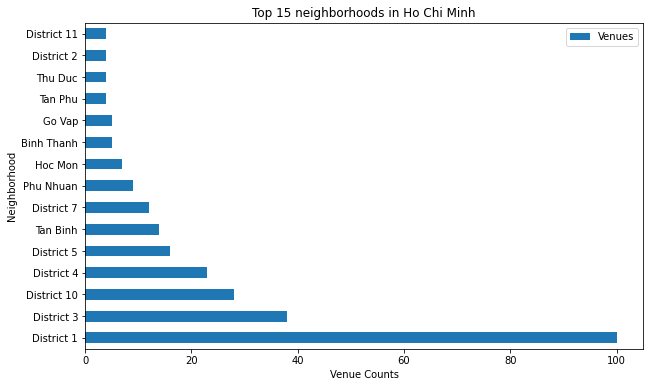

In [15]:
count_df= pd.DataFrame(hcm_venue.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])['Venue'].count()).reset_index(drop = False)
count_df.columns = ['Neighborhood','Latitude','Longitude','Venues']
top10 = count_df.sort_values(by = 'Venues', ascending = False).head(15)
top10 = top10.drop(columns = ['Latitude','Longitude']).set_index('Neighborhood')
top10.plot(kind = 'barh', figsize =(10,6))
plt.xlabel('Venue Counts')
plt.ylabel('Neighborhood')
plt.title('Top 15 neighborhoods in Ho Chi Minh')

### Show top 10 venue categories 

Text(0.5, 1.0, 'Top 10 Venue Category in Ho Chi Minh')

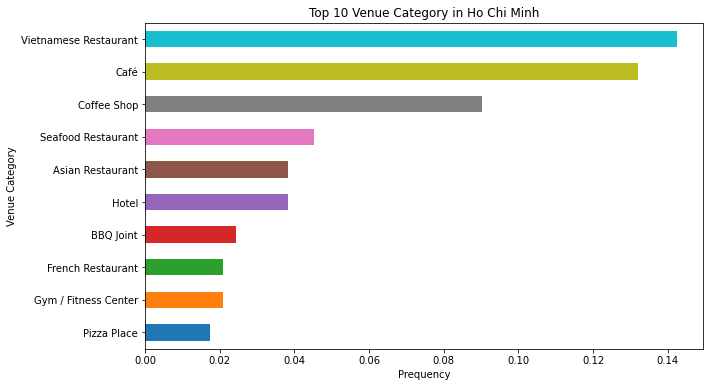

In [16]:
top_venues = pd.get_dummies(hcm_venue['Venue Category'], prefix="", prefix_sep="").mean().sort_values().tail(10)
top_venues.plot(kind ='barh', figsize = (10,6))
plt.xlabel('Prequency')
plt.ylabel('Venue Category')
plt.title('Top 10 Venue Category in Ho Chi Minh')

### Explore each neighborhood

In [17]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venue['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hcm_onehot['Neighborhood'] = hcm_venue['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

hcm_onehot.head()

,Neighborhood,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Cafeteria,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Electronics Store,Flea Market,Flower Shop,Food Court,Food Truck,French Restaurant,German Restaurant,Gift Shop,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Multiplex,Museum,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Pizza Place,Playground,Residential Building (Apartment / Condo),Restaurant,Rock Club,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar
0,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
hcm_onehot.shape

(288, 84)

In [19]:
hcm_grouped = hcm_onehot.groupby('Neighborhood').mean().reset_index()
hcm_grouped

,Neighborhood,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Cafeteria,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Electronics Store,Flea Market,Flower Shop,Food Court,Food Truck,French Restaurant,German Restaurant,Gift Shop,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Multiplex,Museum,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Pizza Place,Playground,Residential Building (Apartment / Condo),Restaurant,Rock Club,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar
0,Binh Chanh,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.0000,0.000,0.0,0.00,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00
1,Binh Tan,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.0000,0.000,0.0,0.00,0.5,0.500000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00
2,Binh Thanh,0.00,0.200000,0.00,0.000000,0.2,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.0000,0.000000,0.000000,0.000000,0.00,0.0000,0.000,0.0,0.00,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00
3,Cu Chi,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0000,0.000000,0.000000,0.000000,0.00,0.0000,0.000,0.0,0.00,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.333333,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.333333,0.00
4,District 1,0.01,0.030000,0.01,0.020000,0.0,0.030000,0.000000,0.00,0.010000,0.02,0.02,0.000000,0.000000,0.010000,0.020000,0.000000,0.080000,0.0000,0.020000,0.110000,0.000000,0.01,0.0000,0.000,0.0,0.01,0.0,0.000000,0.010000,0.01,0.01,0.030000,0.01,0.00,0.000000,0.01,0.01,0.000000,0.10

In [20]:
num_top_venues = 5

for hood in hcm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = hcm_grouped[hcm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Binh Chanh----
                    venue  freq
0      Seafood Restaurant   0.5
1          Breakfast Spot   0.5
2  Argentinian Restaurant   0.0
3              Playground   0.0
4            Optical Shop   0.0


----Binh Tan----
                    venue  freq
0       Electronics Store   0.5
1             Flea Market   0.5
2  Argentinian Restaurant   0.0
3       Mobile Phone Shop   0.0
4            Optical Shop   0.0


----Binh Thanh----
                       venue  freq
0                       Café   0.6
1           Asian Restaurant   0.2
2                     Bakery   0.2
3     Argentinian Restaurant   0.0
4  Middle Eastern Restaurant   0.0


----Cu Chi----
                       venue  freq
0      Vietnamese Restaurant  0.33
1    Health & Beauty Service  0.33
2                       Café  0.33
3     Argentinian Restaurant  0.00
4  Middle Eastern Restaurant  0.00


----District 1----
                   venue  freq
0            Coffee Shop  0.11
1  Vietnamese Restaurant  0.10
2     

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hcm_grouped['Neighborhood']

for ind in np.arange(hcm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Binh Chanh,Seafood Restaurant,Breakfast Spot,Whisky Bar,Cupcake Shop,Dessert Shop,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Electronics Store,Flea Market
1,Binh Tan,Electronics Store,Flea Market,Whisky Bar,Cupcake Shop,Dessert Shop,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Flower Shop,Food Court
2,Binh Thanh,Café,Asian Restaurant,Bakery,Whisky Bar,Food Truck,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Electronics Store,Flea Market
3,Cu Chi,Vietnamese Restaurant,Health & Beauty Service,Café,Food Truck,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Electronics Store,Flea Market,Flower Shop
4,District 1,Coffee Shop,Hotel,Vietnamese Restaurant,Café,French Restaurant,Asian Restaurant,Bar,Burger Joint,Multiplex,Clothing Store


### Elbow method for optimal K

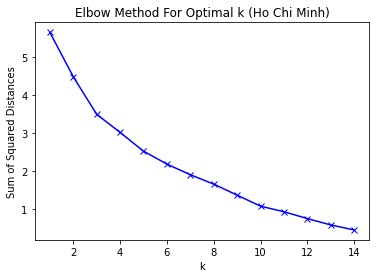

In [25]:
hcm_grouped_clustering = hcm_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(hcm_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k (Ho Chi Minh)')
plt.show()

### K-means clustering

In [26]:
# set number of clusters
kclusters = 3

hcm_grouped_clustering = hcm_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hcm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [28]:
# add clustering labels
#neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1 , inplace = True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hcm_merged = hcm_df

# merge hcm_grouped with hcm_data to add latitude/longitude for each neighborhood
hcm_merged = hcm_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
hcm_merged.dropna(axis = 0, inplace = True)
hcm_merged['Cluster Labels'] = hcm_merged['Cluster Labels'].astype('int')

hcm_merged.drop('Id', axis =1).head() # check the last columns!

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,District 1,187435,10.775659,106.700424,1,Coffee Shop,Hotel,Vietnamese Restaurant,Café,French Restaurant,Asian Restaurant,Bar,Burger Joint,Multiplex,Clothing Store
1,District 2,140621,10.787273,106.749810,1,Restaurant,Vietnamese Restaurant,Snack Place,Whisky Bar,Flower Shop,Dessert Shop,Dim Sum Restaurant,Dog Run,Eastern European Restaurant,Electronics Store
2,District 3,188945,10.784370,106.684409,1,Vietnamese Restaurant,Coffee Shop,Café,French Restaurant,Asian Restaurant,Seafood Restaurant,Rock Club,Juice Bar,Spa,Breakfast Spot
3,District 4,183261,10.757826,106.701297,1,Seafood Restaurant,Café,Vietnamese Restaurant,Gym / Fitness Center,Snack Place,Mexican Restaurant,Clothing Store,Pizza Place,Playground,Cafeteria
4,District 5,174154,10.754028,106.663375,1,Vietnamese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Café,Asian Restaurant,BBQ Joint,Multiplex,Sporting Goods Shop,Gym / Fitness Center,Dessert Shop


### Explore each cluster

In [140]:
cluster_1 = hcm_merged.loc[hcm_merged['Cluster Labels'] == 0, hcm_merged.columns[[1] + list(range(5, hcm_merged.shape[1]))]]
cluster_2 = hcm_merged.loc[hcm_merged['Cluster Labels'] == 1, hcm_merged.columns[[1] + list(range(5, hcm_merged.shape[1]))]]
cluster_3 = hcm_merged.loc[hcm_merged['Cluster Labels'] == 2, hcm_merged.columns[[1] + list(range(5, hcm_merged.shape[1]))]]
#cluster_4 = hcm_merged.loc[hcm_merged['Cluster Labels'] == 3, hcm_merged.columns[[1] + list(range(5, hcm_merged.shape[1]))]]
#cluster_5 = hcm_merged.loc[hcm_merged['Cluster Labels'] == 4, hcm_merged.columns[[1] + list(range(5, hcm_merged.shape[1]))]]

In [141]:
print('-----------Cluster 1------------')
cluster_1.iloc[:,2:3].apply(pd.Series.value_counts)

-----------Cluster 1------------


,1st Most Common Venue
Café,2
Asian Restaurant,1


In [142]:
print('-----------Cluster 2------------')
cluster_2.iloc[:,2:3].apply(pd.Series.value_counts)

-----------Cluster 2------------


,1st Most Common Venue
Vietnamese Restaurant,8
Seafood Restaurant,3
Café,2
Coffee Shop,2
Restaurant,1
Pizza Place,1
Electronics Store,1


In [143]:
print('-----------Cluster 3------------')
cluster_3.iloc[:,2:3].apply(pd.Series.value_counts)

-----------Cluster 3------------


,1st Most Common Venue
Flower Shop,1
